nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

In [2]:
#import torch
#from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import nltk
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import ne_chunk, word_tokenize, pos_tag
import dask.dataframe as dd
from dask.multiprocessing import get
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# load the data #
sample_submission = pd.read_csv('/content/sample_submission.csv')
prompts_train = pd.read_csv('/content/prompts_train.csv')
prompts_test = pd.read_csv('/content/prompts_test.csv')
summaries_train = pd.read_csv('/content/summaries_train.csv')
summaries_test = pd.read_csv('/content/summaries_test.csv')

In [4]:
# Load and preprocess your data (assumed)
# summaries_train, prompts_train, summaries_test, prompts_test = ...

# Merge train data based on prompt ID
train_data = summaries_train.merge(prompts_train, on='prompt_id', how='left')

# Add a 'type' column and set it to 'train'
train_data['type'] = 'train'

# Merge test data based on prompt ID
test_data = summaries_test.merge(prompts_test, on='prompt_id', how='left')

# Add a 'type' column and set it to 'test'
test_data['type'] = 'test'

# Combine train and test data
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Extract features: word counts, sentence lengths, vocabulary richness
combined_data['word_count'] = combined_data['text'].apply(lambda x: len(x.split()))
combined_data['sentence_length'] = combined_data['text'].apply(lambda x: len(x.split('.')))
combined_data['vocabulary_richness'] = combined_data['text'].apply(lambda x: len(set(x.split())))


# Additional features
combined_data['avg_word_length'] = combined_data['text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
combined_data['comma_count'] = combined_data['text'].apply(lambda x: x.count(','))
combined_data['semicolon_count'] = combined_data['text'].apply(lambda x: x.count(';'))

#pos ratios
def calculate_pos_ratios(text):
    pos_tags = pos_tag(nltk.word_tokenize(text))
    pos_counts = Counter(tag for word, tag in pos_tags)
    total_words = len(pos_tags)
    ratios = {tag: count / total_words for tag, count in pos_counts.items()}
    return ratios


# Calculate POS ratios for each row
combined_data['pos_ratios'] = combined_data['text'].apply(calculate_pos_ratios)

# Convert the dictionary of POS ratios into a single value (mean)
combined_data['pos_mean'] = combined_data['pos_ratios'].apply(lambda x: np.mean(list(x.values())))

sid = SentimentIntensityAnalyzer()
def calculate_sentiment_scores(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores
 
#Calculate sentiment scores for each row
combined_data['sentiment_scores'] = combined_data['text'].apply(calculate_sentiment_scores)

# Convert sentiment_scores into individual columns
sentiment_columns = pd.DataFrame(list(combined_data['sentiment_scores']))
combined_data = pd.concat([combined_data, sentiment_columns], axis=1)


# Additional features
combined_data['exclamation_count'] = combined_data['text'].apply(lambda x: x.count('!'))
combined_data['question_count'] = combined_data['text'].apply(lambda x: x.count('?'))
combined_data['quote_count'] = combined_data['text'].apply(lambda x: x.count('"'))

def calculate_unique_words(text):
    unique_words = set(text.split())
    return len(unique_words)

combined_data['unique_word_count'] = combined_data['text'].apply(calculate_unique_words)

def calculate_punctuation_ratios(text):
    total_chars = len(text)
    punctuation_counts = Counter(char for char in text if char in '.,!?;:"()[]{}')
    ratios = {char: count / total_chars for char, count in punctuation_counts.items()}
    return ratios

combined_data['punctuation_ratios'] = combined_data['text'].apply(calculate_punctuation_ratios)

# Convert the dictionary of punctuation ratios into a single value (sum)
combined_data['punctuation_sum'] = combined_data['punctuation_ratios'].apply(lambda x: np.sum(list(x.values())))

# words overlap
combined_data['word_overlap'] = combined_data.apply(lambda row: len(set(row['prompt_text'].split()) & set(row['text'].split())), axis=1)

# prompt length
combined_data['prompt_length'] = combined_data['prompt_text'].apply(lambda x: len(x.split()))

# text to prompt ratio
combined_data['text_to_prompt_ratio'] = combined_data['word_count'] / combined_data['prompt_length']

print('prompt ratio done')

# keyword density
def calculate_keyword_density(row):
    keywords = set(row['prompt_text'].split())
    text_words = row['text'].split()
    keyword_count = sum(1 for word in text_words if word in keywords)
    return keyword_count / len(text_words)

combined_data['keyword_density'] = combined_data.apply(calculate_keyword_density, axis=1)
print('keyword density done')

# Function to calculate sentiment scores for prompt text
sid = SentimentIntensityAnalyzer()
def calculate_sentiment_scores_prompt(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

# Calculate sentiment scores for prompt text
combined_data['sentiment_scores_prompt'] = combined_data['prompt_text'].apply(calculate_sentiment_scores_prompt)

# Convert sentiment_scores_prompt into individual columns
sentiment_columns_prompt = pd.DataFrame(list(combined_data['sentiment_scores_prompt']))
sentiment_columns_prompt.columns = [col +'_prompt' for col in sentiment_columns_prompt.columns]

combined_data = pd.concat([combined_data, sentiment_columns_prompt], axis=1)
print('sentiment_scores_prompt done')

# Jaccard similarity between prompt text and text
combined_data['jaccard_similarity'] = combined_data.apply(lambda row: len(set(word_tokenize(row['prompt_text'])) & set(word_tokenize(row['text']))) / len(set(word_tokenize(row['prompt_text'])) | set(word_tokenize(row['text']))), axis=1)

combined_data.columns

prompt ratio done
keyword density done
sentiment_scores_prompt done


Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'prompt_question', 'prompt_title', 'prompt_text', 'type', 'word_count',
       'sentence_length', 'vocabulary_richness', 'avg_word_length',
       'comma_count', 'semicolon_count', 'pos_ratios', 'pos_mean',
       'sentiment_scores', 'neg', 'neu', 'pos', 'compound',
       'exclamation_count', 'question_count', 'quote_count',
       'unique_word_count', 'punctuation_ratios', 'punctuation_sum',
       'word_overlap', 'prompt_length', 'text_to_prompt_ratio',
       'keyword_density', 'sentiment_scores_prompt', 'neg_prompt',
       'neu_prompt', 'pos_prompt', 'compound_prompt', 'jaccard_similarity'],
      dtype='object')

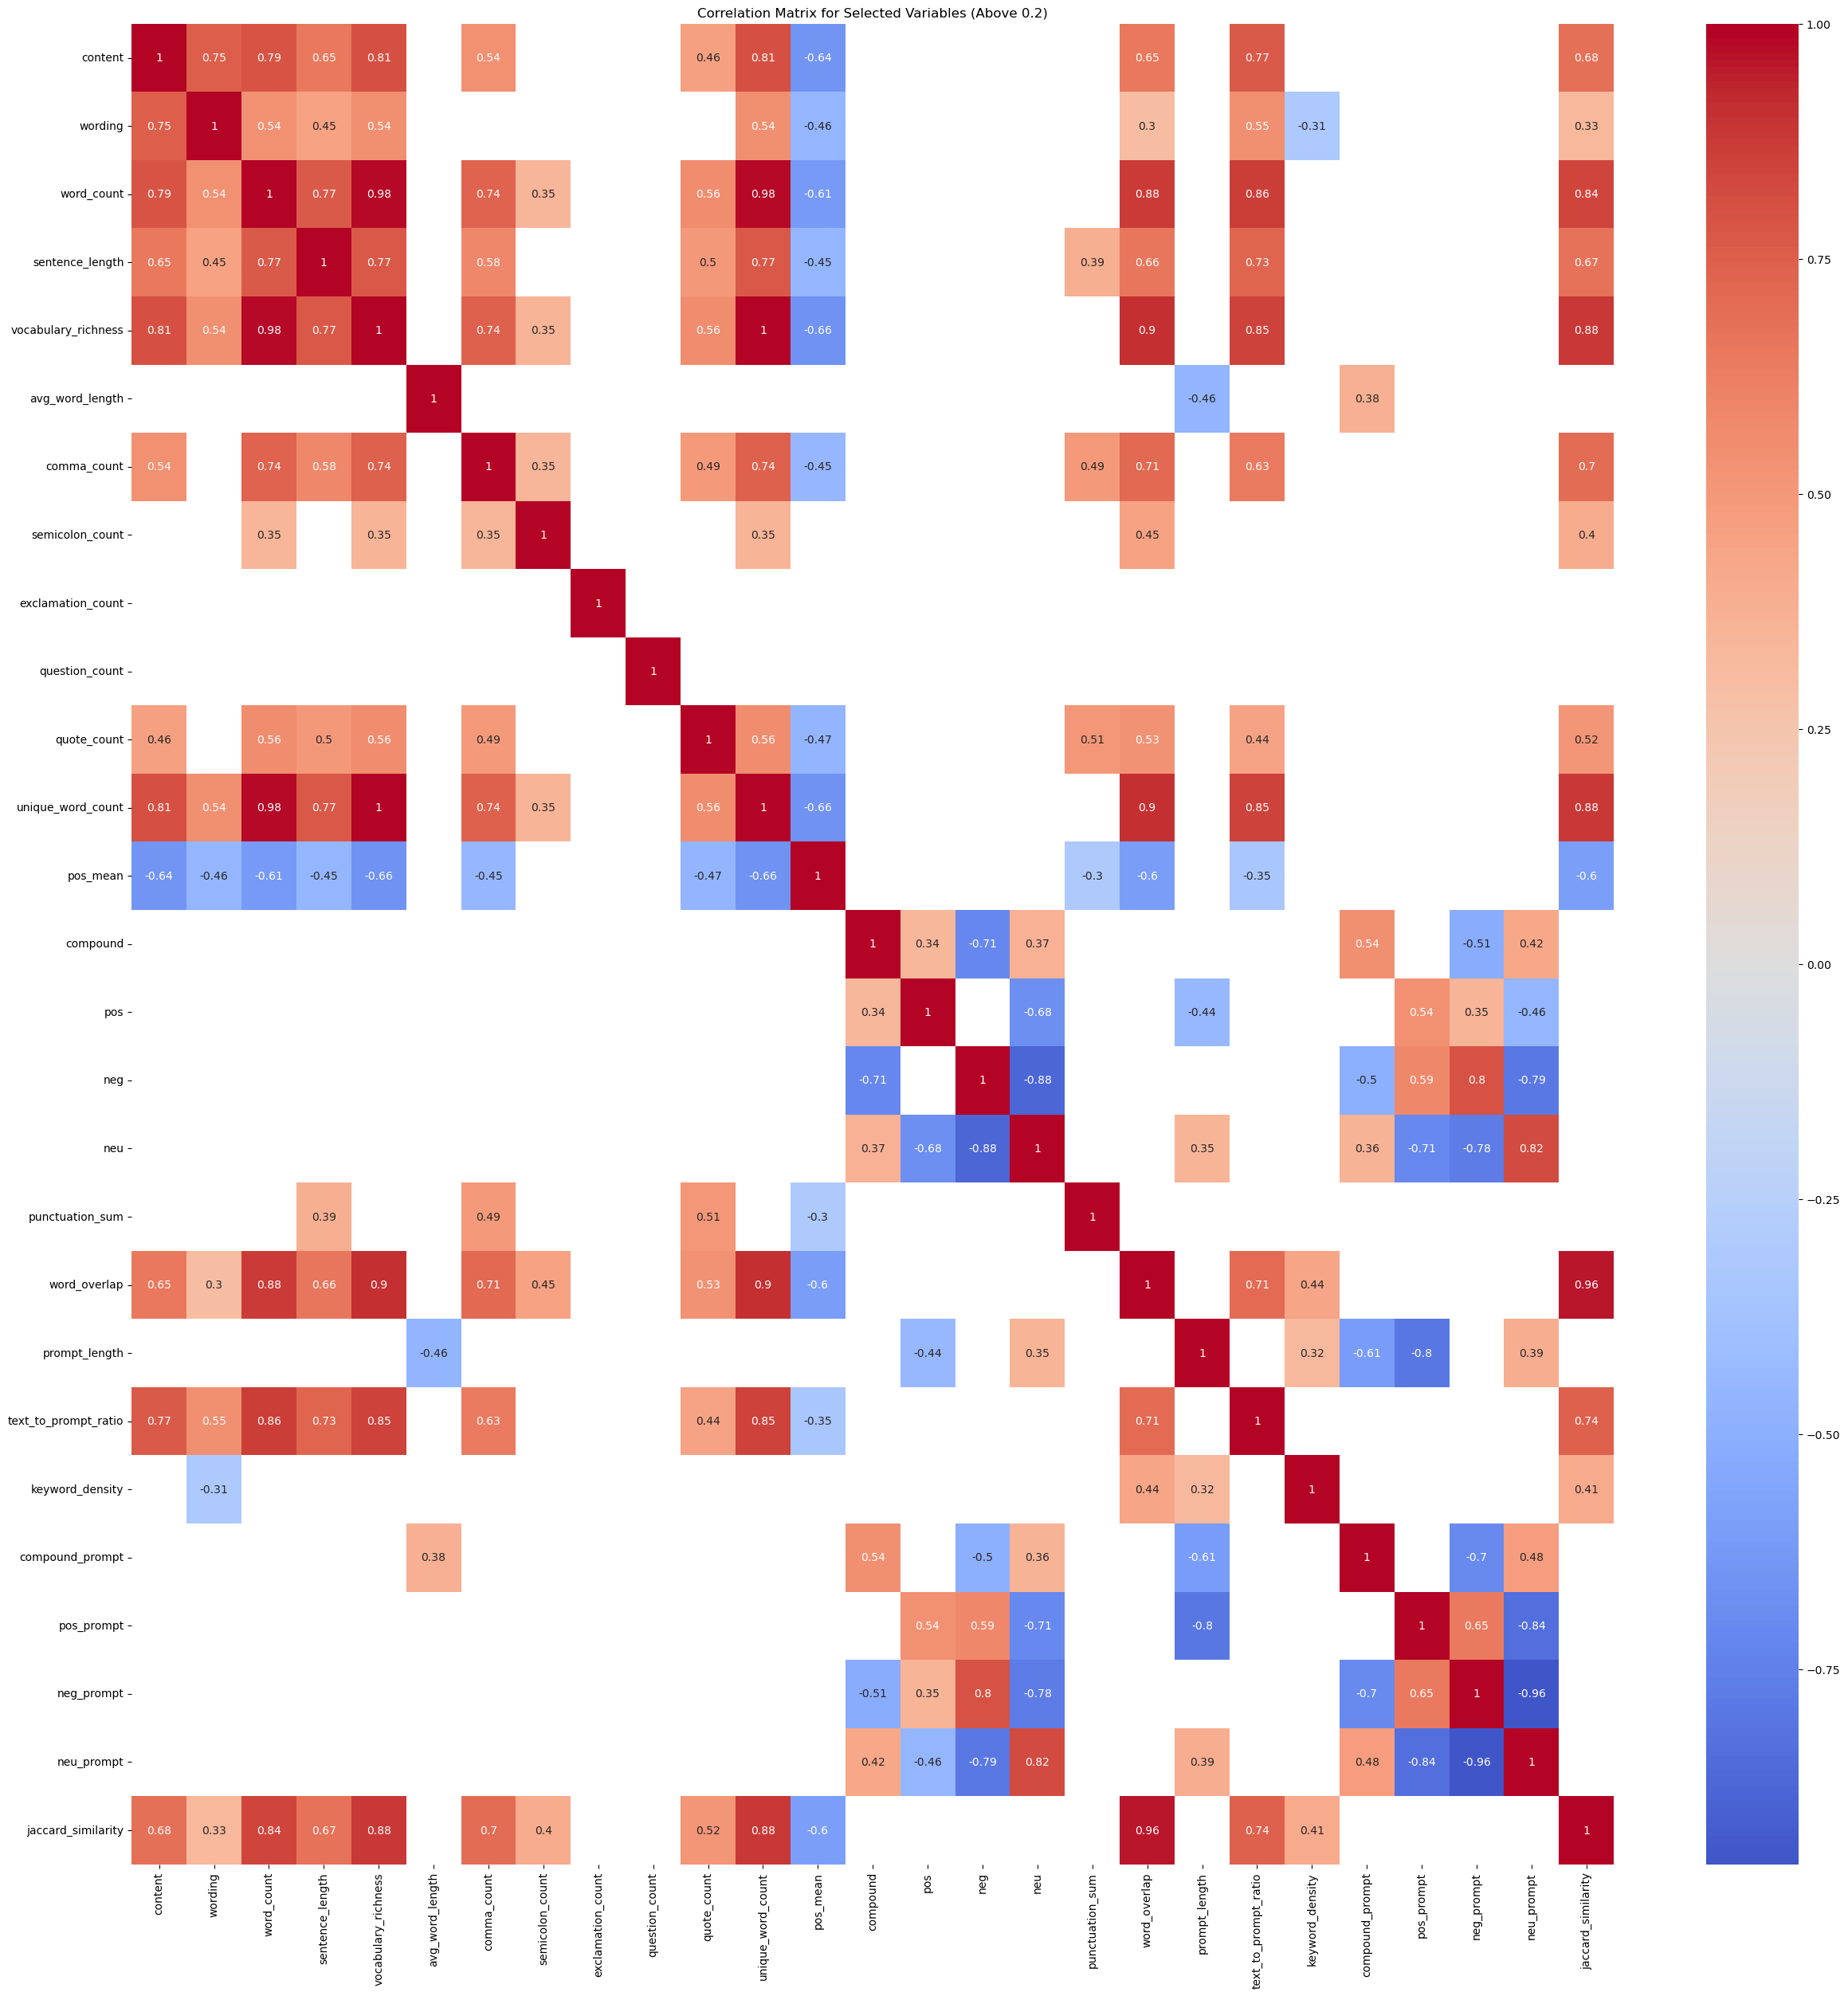

In [5]:
# List of selected variables for analysis
selected_vars = ['content', 'wording', 'word_count', 'sentence_length', 'vocabulary_richness', 'avg_word_length',
                   'comma_count', 'semicolon_count', 'exclamation_count', 'question_count',
                   'quote_count', 'unique_word_count', 'pos_mean', 'compound', 'pos', 'neg', 'neu',
                   'punctuation_sum', 'word_overlap', 'prompt_length', 'text_to_prompt_ratio', 'keyword_density'
                  ,'compound_prompt', 'pos_prompt', 'neg_prompt', 'neu_prompt', 'jaccard_similarity']

# Create a subset DataFrame with selected variables
subset_df = combined_data[selected_vars]

# Calculate the correlation matrix for the subset
correlation_matrix = subset_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30, 30))


# Create a mask to hide values below the threshold
mask = correlation_matrix.applymap(lambda x: abs(x) <= 0.3)

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix for Selected Variables (Above 0.2)")
plt.show()

In [6]:
# Update the list of features

feature_columns = ['word_count', 'sentence_length', 'vocabulary_richness', 'avg_word_length',
                   'comma_count', 'semicolon_count', 'exclamation_count', 'question_count',
                   'quote_count', 'unique_word_count', 'pos_mean', 'compound', 'pos', 'neg', 'neu',
                   'punctuation_sum', 'word_overlap', 'prompt_length', 'text_to_prompt_ratio', 'keyword_density'
                  ,'compound_prompt', 'pos_prompt', 'neg_prompt', 'neu_prompt', 'jaccard_similarity']


# Split data into features and target variables
train_features = combined_data[combined_data['type'] == 'train'][feature_columns]
test_features = combined_data[combined_data['type'] == 'test'][feature_columns]

train_content = combined_data[combined_data['type'] == 'train']['content']
train_wording = combined_data[combined_data['type'] == 'train']['wording']

In [7]:
def calculate_metrics(model, train_features, train_target):
    # Fit the model
    model.fit(train_features, train_target)
    
    # Make predictions
    train_pred = model.predict(train_features)
    
    # Calculate squared errors
    squared_errors = (train_pred - train_target) ** 2
    
    # Calculate mean squared error (MSE)
    mse = np.mean(squared_errors, axis=0)
    
    # Calculate root mean squared error (RMSE)
    rmse = np.sqrt(mse)
    
    return mse, rmse

# Initialize the models
model_content = GradientBoostingRegressor()
model_wording = GradientBoostingRegressor()

# Calculate metrics for content and wording predictions
content_mse, content_rmse = calculate_metrics(model_content, train_features, train_content)
wording_mse, wording_rmse = calculate_metrics(model_wording, train_features, train_wording)

# Calculate MCRMSE as the mean of individual RMSE values
mcrmse_individual = np.mean([content_rmse, wording_rmse])

# Cross-validation using cross_val_score for both models
cv_scores_content = cross_val_score(model_content, train_features, train_content, scoring='neg_mean_squared_error', cv=5)
cv_rmse_scores_content = np.sqrt(-cv_scores_content)
average_cv_rmse_content = np.mean(cv_rmse_scores_content)

cv_scores_wording = cross_val_score(model_wording, train_features, train_wording, scoring='neg_mean_squared_error', cv=5)
cv_rmse_scores_wording = np.sqrt(-cv_scores_wording)
average_cv_rmse_wording = np.mean(cv_rmse_scores_wording)

# Calculate the mean of cross-validated RMSE values
average_cv_rmse = (average_cv_rmse_content + average_cv_rmse_wording) / 2

print("Content RMSE:", content_rmse)
print("Wording RMSE:", wording_rmse)
print("Individual MCRMSE:", mcrmse_individual)
print("Cross-Validation RMSE (Content):", average_cv_rmse_content)
print("Cross-Validation RMSE (Wording):", average_cv_rmse_wording)
print("Mean Cross-Validation RMSE (Content and Wording):", average_cv_rmse)


Content RMSE: 0.4078133616839073
Wording RMSE: 0.5401626600210825
Individual MCRMSE: 0.47398801085249487
Cross-Validation RMSE (Content): 0.4409053525680894
Cross-Validation RMSE (Wording): 0.5831461571473266
Mean Cross-Validation RMSE (Content and Wording): 0.5120257548577081
